In [1]:
# Setup imports and path for local modules
import sys
sys.path.append("../src")

from data_preprocessing import load_and_preprocess
from hpo_optuna import run_optimization
from train_model import train
from batch_inference import batch_predict
# from drift_detection import detect_drift  # Optional bonus

import joblib
import mlflow
import pandas as pd

df = pd.read_csv("../data/diabetes.csv")
print(df.columns)
df.head()


# Step 1: Preprocess Data
X_train, X_test, y_train, y_test, scaler = load_and_preprocess("../data/diabetes.csv")
joblib.dump(scaler, "../models/scaler.pkl")  # Save scaler for inference



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['PatientID', 'Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
       'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age',
       'Diabetic'],
      dtype='object')


['../models/scaler.pkl']

In [2]:
# Step 2: Hyperparameter Tuning with Optuna
best_params = run_optimization()
print("Best Parameters:", best_params)


[I 2025-07-19 15:46:44,531] A new study created in memory with name: no-name-b022e62a-78b7-454f-93fa-c143f699b3a0
[I 2025-07-19 15:46:45,240] Trial 0 finished with value: 0.988105685161493 and parameters: {'n_estimators': 94, 'max_depth': 2, 'learning_rate': 0.1685875688225031}. Best is trial 0 with value: 0.988105685161493.
[I 2025-07-19 15:46:45,983] Trial 1 finished with value: 0.9879832895326335 and parameters: {'n_estimators': 105, 'max_depth': 2, 'learning_rate': 0.13579420770574724}. Best is trial 0 with value: 0.988105685161493.
[I 2025-07-19 15:46:50,158] Trial 2 finished with value: 0.9854522403018785 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.1542425304770951}. Best is trial 0 with value: 0.988105685161493.
[I 2025-07-19 15:46:52,660] Trial 3 finished with value: 0.989437026294276 and parameters: {'n_estimators': 121, 'max_depth': 6, 'learning_rate': 0.1393394187793234}. Best is trial 3 with value: 0.989437026294276.
[I 2025-07-19 15:46:54,389]

Best trial: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.10669109577742919}
Best Parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.10669109577742919}


In [3]:
# Step 3: Train final model using best parameters
best_model, acc, auc = train(X_train, X_test, y_train, y_test, best_params)
print(f"Final Accuracy: {acc:.4f}, AUC: {auc:.4f}")


2025/07/19 15:48:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 15:48:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved to ../models/model.pkl
Final Accuracy: 0.9490, AUC: 0.9911


In [4]:
# Step 4: Model Registration

# 1. Import the register_model function from your script
from model_registration import register_model

import mlflow
mlflow.end_run() # End any active run

# 2. Call it with your final model and test data
acc, auc = register_model(best_model, X_test, y_test, best_params)

print("Final Accuracy:", acc)
print("Final AUC:", auc)


2025/07/19 15:48:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Final model saved at: models/final_model.pkl


2025/07/19 15:48:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model registered to MLflow
Final Accuracy: 0.949
Final AUC: 0.9911216982047102


In [5]:
# Step 5: Run Batch Inference on New Data (diabetes2.csv)
import sys
sys.path.append("../src")

from batch_inference import batch_predict  # import after adding path

import joblib
import pandas as pd

# Paths
model_path = "../models/model.pkl"
scaler_path = "../models/scaler.pkl"
input_csv_path = "../data/diabetes2.csv"
output_csv_path = "../output/predictions.csv"

# Load scaler
scaler = joblib.load(scaler_path)

# Run batch inference
batch_predict(model_path, scaler, input_csv_path, output_csv_path)

# Preview some predictions
predictions = pd.read_csv(output_csv_path)
print(predictions.head())



Saved predictions to ../output/predictions.csv
   PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1142956            1             78                      41   
1    1823377            0            116                      92   
2    1916381            8            171                      42   
3    1247480            3            108                      63   
4    1516947            8            153                      99   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  \
0                33           311  50.796392          0.420804   24         0   
1                16           184  18.603630          0.131156   22         0   
2                29           160  35.482247          0.082671   22         1   
3                45           297  49.375169          0.100979   46         1   
4                15            41  35.062139          0.116191   22         1   

   prediction  prediction_prob  
0           0         0.

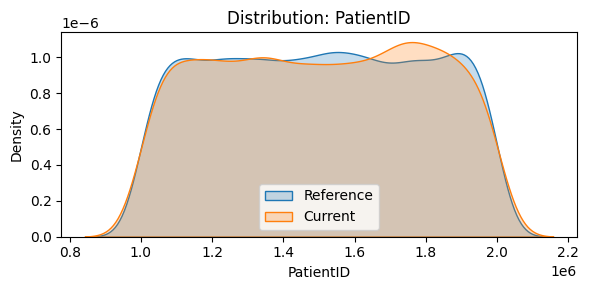

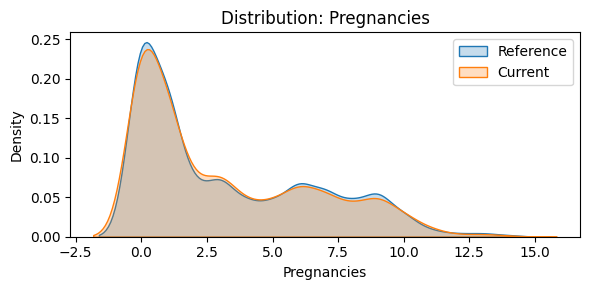

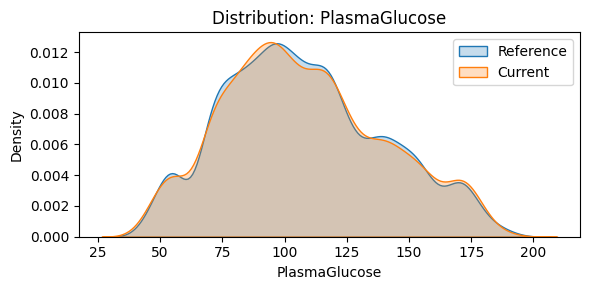

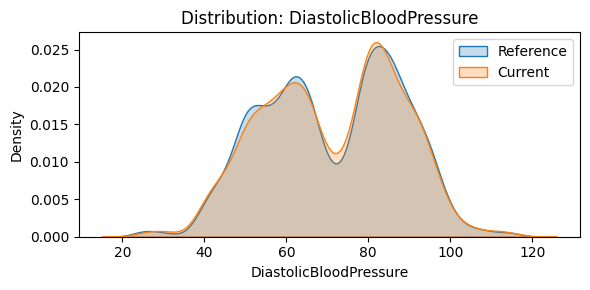

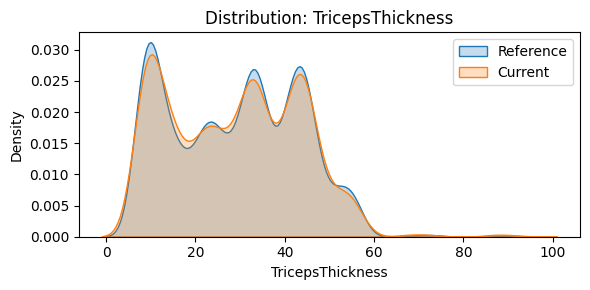

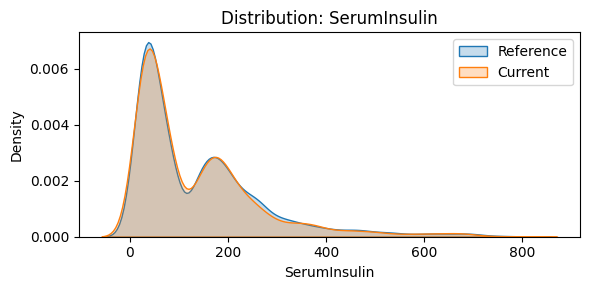

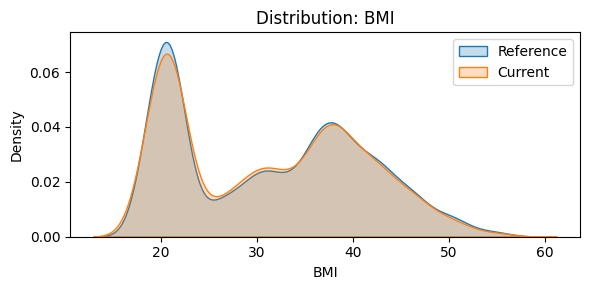

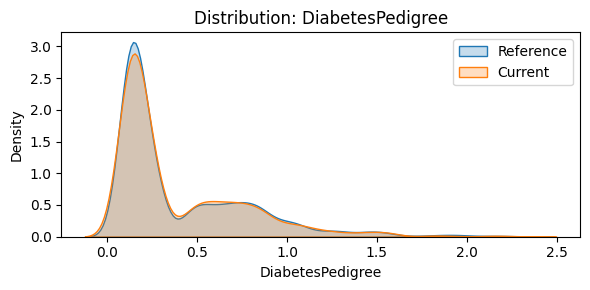

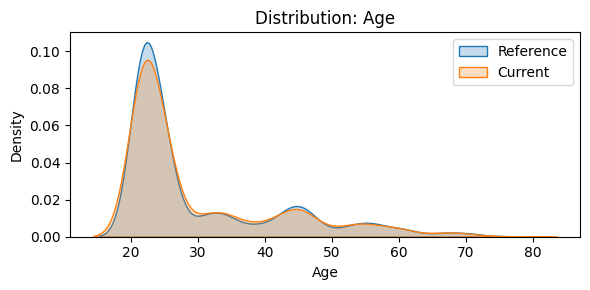

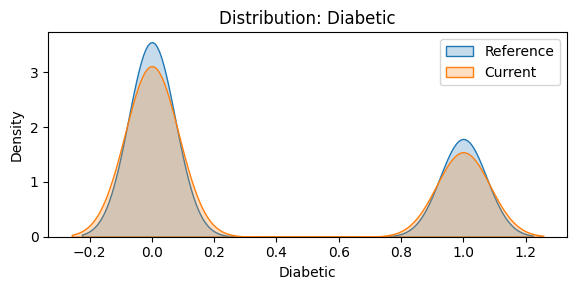

,feature,type,test,p_value,drift
0,PatientID,numerical,KS-test,0.492550,False
1,Pregnancies,numerical,KS-test,0.492550,False
2,PlasmaGlucose,numerical,KS-test,0.997791,False
3,DiastolicBloodPressure,numerical,KS-test,0.702386,False
4,TricepsThickness,numerical,KS-test,0.939651,False
5,SerumInsulin,numerical,KS-test,0.134659,False
6,BMI,numerical,KS-test,0.457119,False
7,DiabetesPedigree,numerical,KS-test,0.731134,False
8,Age,numerical,KS-test,0.846719,False
9,Diabetic,numerical,KS-test,1.000000,False


In [2]:
#(Optional Bonus) Data Drift Detection

import sys
sys.path.append('../src')  # Adjust path based on where the src/ folder is

from drift_detection import detect_drift

# Run the function and get results
results = detect_drift("../data/diabetes.csv", "../data/diabetes2.csv", show_plots=True)

# Display results
import pandas as pd
result_df = pd.DataFrame(results)
result_df



In [4]:
import evidently
print(evidently.__version__)


0.7.11
